
=== Final Model Performance ===
Mathematical Expression:
Training Set Classification Accuracy: 66.87%
Test Set Classification Accuracy: 64.29%
Confusion Matrix (Train):
 [[38  0 50]
 [ 0  0  5]
 [ 0  0 73]]
Confusion Matrix (Test):
 [[ 9  0 14]
 [ 0  0  1]
 [ 0  0 18]]


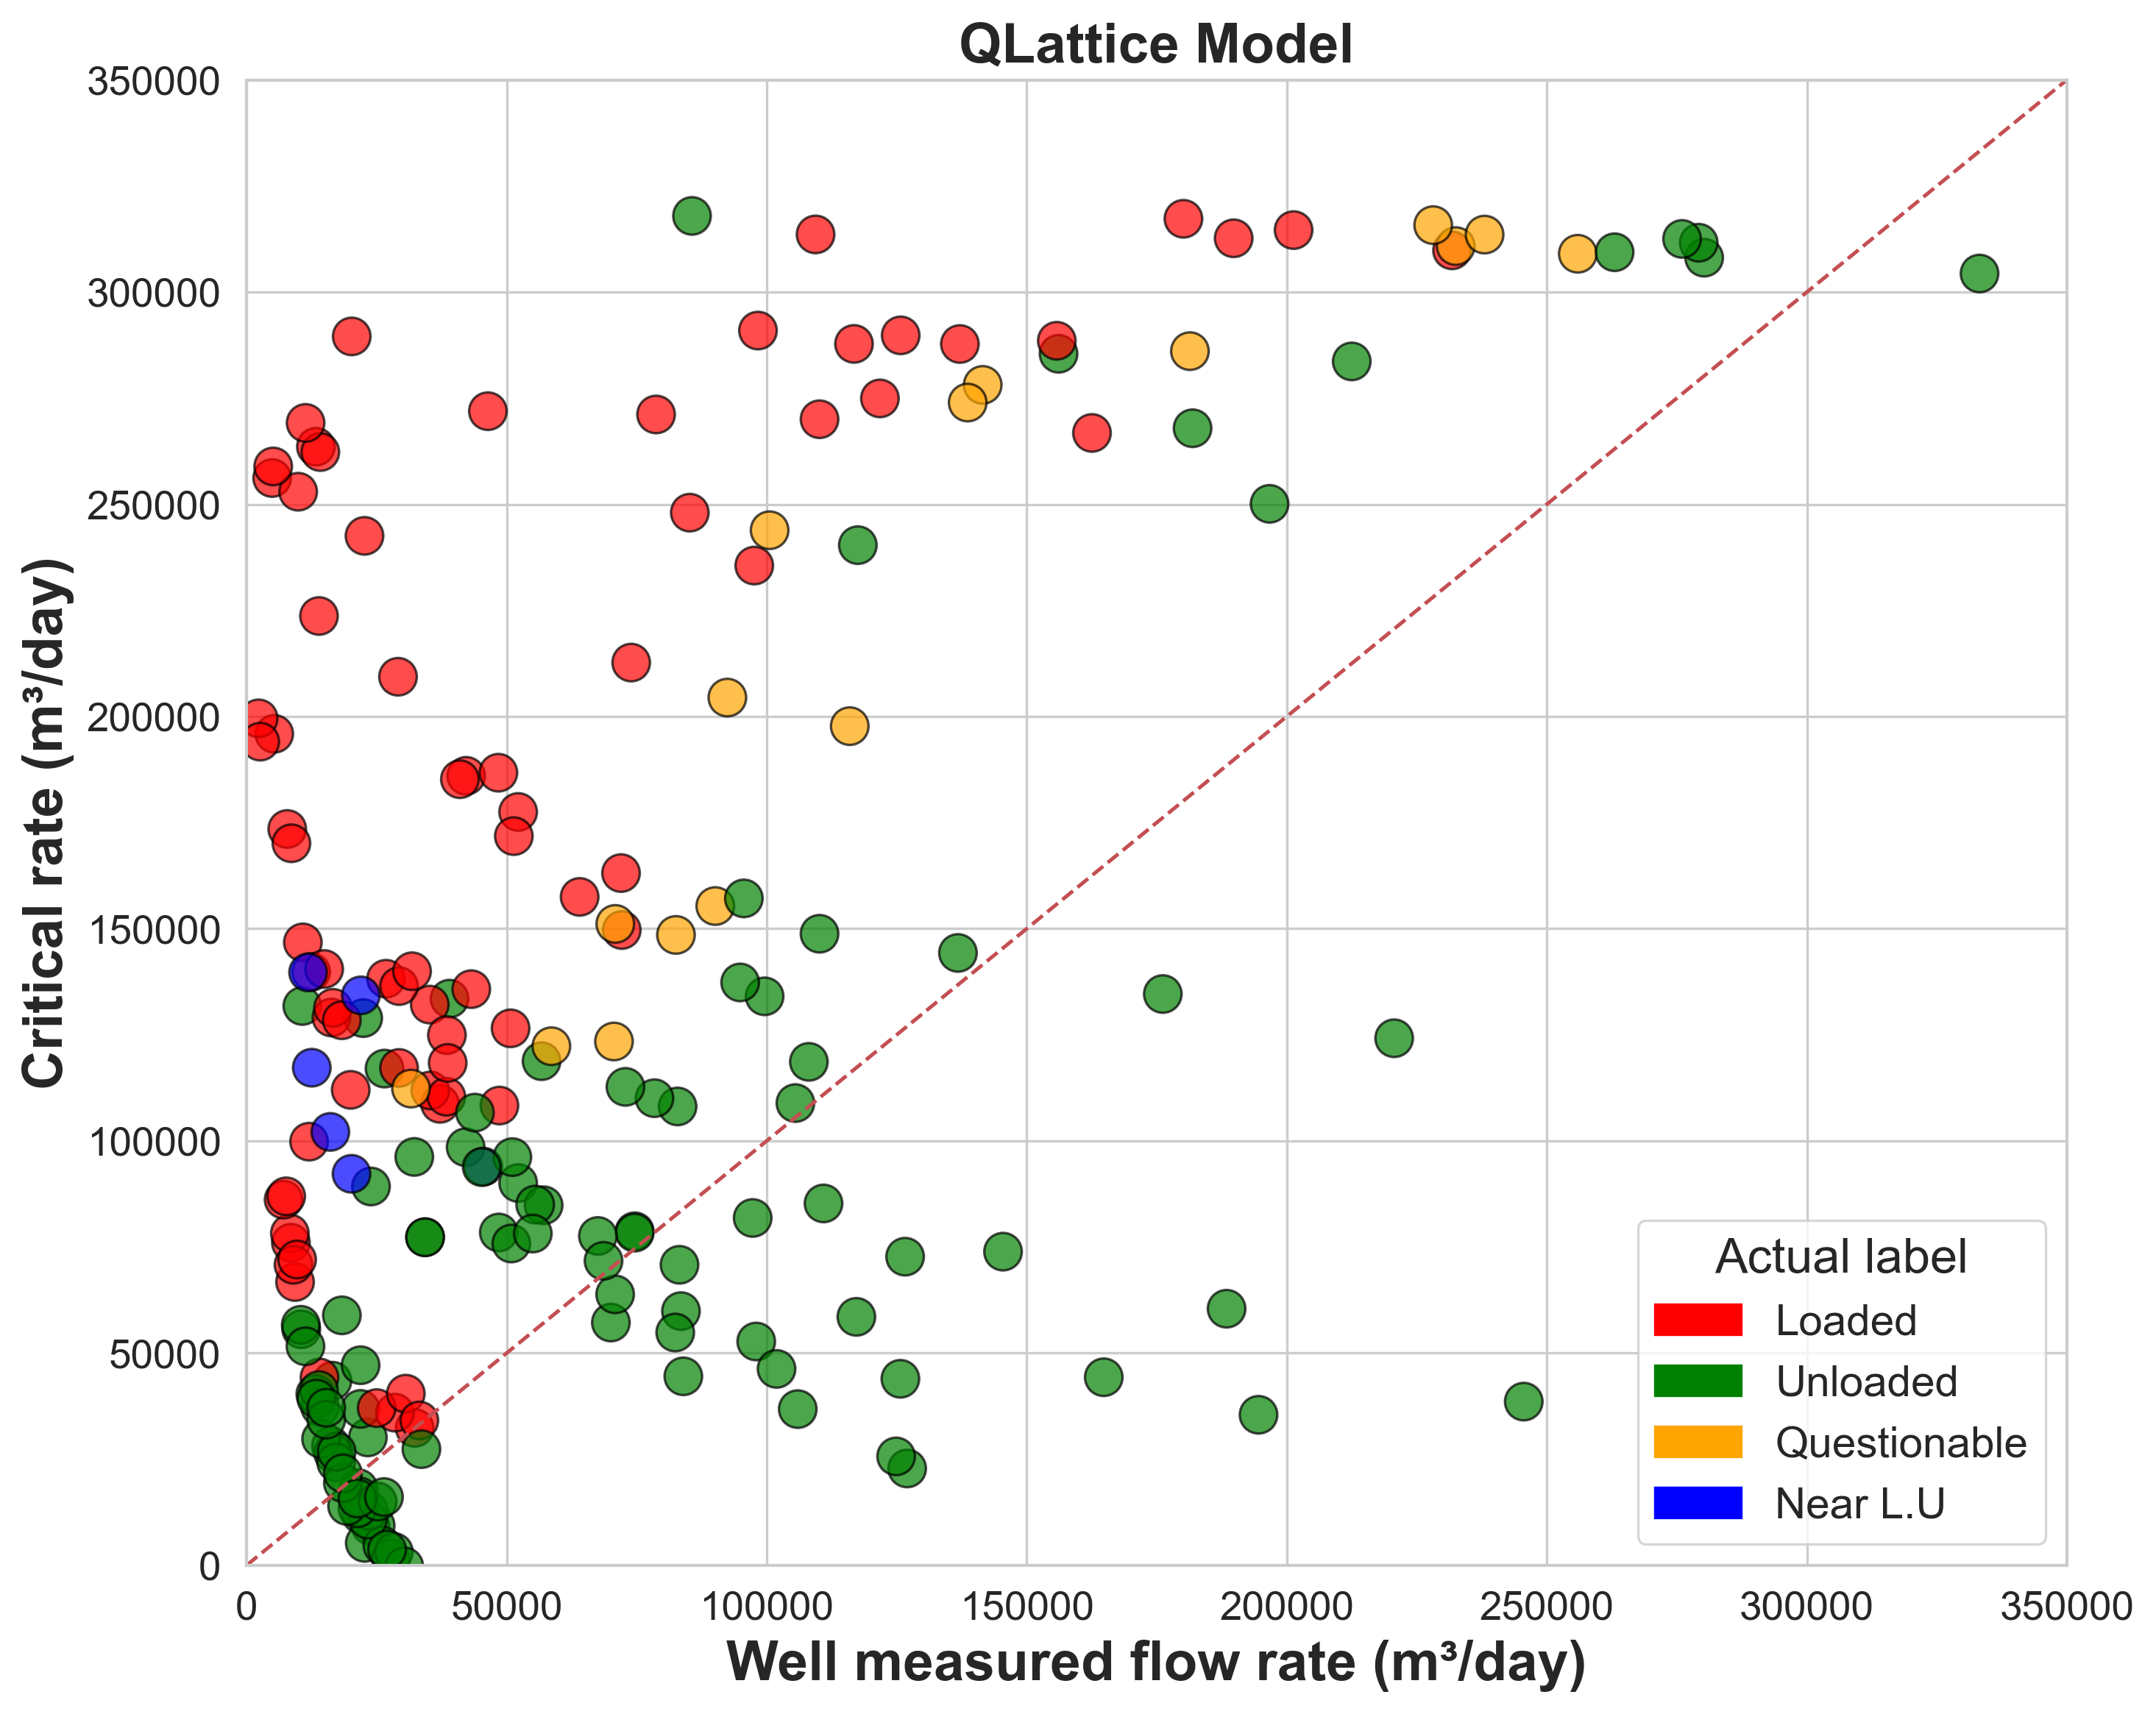

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import feyn

# Connect to QLattice
ql = feyn.connect_qlattice()

# Load data
df = pd.read_csv(r'C:\Users\awwalola\Downloads\processed_well_data.csv')

# Define features and targets
features = ['Dia', 'Dev(deg)', 'Area (m2)', 'z', 'GasDens', 'LiquidDens', 'g (m/s2)', 'P/T', 'friction_factor', 'critical_film_thickness']
output = 'Qcr'
gasflow = 'Gasflowrate'
status_col = 'Test status'

# Map Test status to numerical classes
loading_class_map = {'Unloaded': -1, 'Near L.U': 0, 'Loaded': 1, 'Questionable': 1}
df['loading_class'] = df[status_col].map(loading_class_map)

# Split data
X = df[features]
y = df[output]
gsflow = df[gasflow]
loading_class = df['loading_class']
X_train, X_test, y_train, y_test, gsflow_train, gsflow_test, loading_train, loading_test = train_test_split(
    X, y, gsflow, loading_class, test_size=0.2, random_state=42, stratify=loading_class
)

# Scale features and target
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
X_scaled = scaler_X.transform(X)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()
y_scaled = scaler_y.transform(y.values.reshape(-1, 1)).flatten()

# Create DataFrames for QLattice
train_df = pd.DataFrame(X_train_scaled, columns=features)
train_df[output] = y_train_scaled
test_df = pd.DataFrame(X_test_scaled, columns=features)
test_df[output] = y_test_scaled
full_df = pd.DataFrame(X_scaled, columns=features)
full_df[output] = y_scaled

# Accuracy calculation
def calculate_accuracy(y_pred, gsflow, loading_actual, interval=0):
    y_pred = np.array(y_pred)
    gsflow = np.array(gsflow)
    loading_pred = np.where(y_pred > gsflow + interval, 1, 
                           np.where(y_pred < gsflow - interval, -1, 0))
    return accuracy_score(loading_actual, loading_pred), confusion_matrix(loading_actual, loading_pred, labels=[-1, 0, 1])

# Cross-validation



def evaluate_qlattice(ql, train_df, loading_class, cv_splits=5, max_complexity=10):
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42)
    acc_scores = []
    
    for train_idx, val_idx in cv.split(train_df[features], loading_class):
        train_fold = train_df.iloc[train_idx]
        val_fold = train_df.iloc[val_idx]
        gsflow_val = gsflow_train.iloc[val_idx] if isinstance(gsflow_train, pd.Series) else gsflow_train[val_idx]
        loading_val = loading_class.iloc[val_idx] if isinstance(loading_class, pd.Series) else loading_class[val_idx]
        
        models = ql.auto_run(train_fold, output_name=output, criterion='bic', max_complexity=max_complexity)
        best_model = models[0]
        
        y_val_pred_scaled = best_model.predict(val_fold[features])
        y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled.reshape(-1, 1)).flatten()
        
        acc, _ = calculate_accuracy(y_val_pred, gsflow_val, loading_val)
        acc_scores.append(acc)
    
    return np.mean(acc_scores)




# Evaluate with cross-validation
cv_score = evaluate_qlattice(ql, train_df, loading_train)
print(f"Cross-validation accuracy: {cv_score*100:.2f}%")

# Train final model
models = ql.auto_run(train_df, output_name=output, criterion='bic', max_complexity=10)
best_model = models[0]

# Predict on train and test sets
y_train_pred_scaled = best_model.predict(train_df[features])
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).flatten()
y_test_pred_scaled = best_model.predict(test_df[features])
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()

# Calculate metrics
train_acc, train_cm = calculate_accuracy(y_train_pred, gsflow_train, loading_train)
test_acc, test_cm = calculate_accuracy(y_test_pred, gsflow_test, loading_test)

print("\n=== Final Model Performance ===")
print("Mathematical Expression:")
print(best_model)
print(f"Training Set Classification Accuracy: {train_acc*100:.2f}%")
print(f"Test Set Classification Accuracy: {test_acc*100:.2f}%")
print("Confusion Matrix (Train):\n", train_cm)
print("Confusion Matrix (Test):\n", test_cm)

# Visualization
color_map = {'Loaded': 'red', 'Unloaded': 'green', 'Questionable': 'orange', 'Near L.U': 'blue'}
y_pred_scaled = best_model.predict(full_df[features])
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
colors = df[status_col].map(color_map).fillna('gray')

plt.figure(figsize=(10, 8), dpi=300)
sns.set_theme(style="whitegrid", context="paper", font_scale=1.5)
plt.scatter(gsflow, y_pred, c=colors, alpha=0.7, s=150, edgecolors="black")
plt.plot([0, 350000], [0, 350000], '--r')
plt.title("QLattice Model", fontsize=18, fontweight='bold')
plt.xlabel("Well measured flow rate (m³/day)", fontsize=18, fontweight='bold')
plt.ylabel("Critical rate (m³/day)", fontsize=18, fontweight='bold')
plt.grid(True)
plt.xlim(0, 350000)
plt.ylim(0, 350000)
legend_patches = [mpatches.Patch(color=color, label=status) for status, color in color_map.items()]
plt.legend(handles=legend_patches, title='Actual label', fontsize=14, title_fontsize=16)
plt.tight_layout()
plt.savefig("qlattice_scatter.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()

In [4]:
print(best_model.sympify())

0.32016*P/T + 1.8481*tanh(0.782471*Area (m2) + 0.242602*criticalfilmthickness + 0.451526) - 0.460206


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import feyn
import matplotlib as mpl

# Set matplotlib to use LaTeX for text rendering
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Computer Modern']
mpl.rcParams['font.size'] = 14

# Connect to QLattice
ql = feyn.connect_qlattice()

# Load data
df = pd.read_csv(r'C:\Users\awwalola\Downloads\processed_well_data.csv')

# Define features and targets
features = ['Dia', 'Dev(deg)', 'Area (m2)', 'z', 'GasDens', 'LiquidDens', 'g (m/s2)', 'P/T', 'friction_factor', 'critical_film_thickness']
output = 'Qcr'
gasflow = 'Gasflowrate'
status_col = 'Test status'

# Map Test status to numerical classes
loading_class_map = {'Unloaded': -1, 'Near L.U': 0, 'Loaded': 1, 'Questionable': 1}
df['loading_class'] = df[status_col].map(loading_class_map)

# Split data
X = df[features]
y = df[output]
gsflow = df[gasflow]
loading_class = df['loading_class']
X_train, X_test, y_train, y_test, gsflow_train, gsflow_test, loading_train, loading_test = train_test_split(
    X, y, gsflow, loading_class, test_size=0.2, random_state=42, stratify=loading_class
)

# Scale features and target
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
X_scaled = scaler_X.transform(X)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()
y_scaled = scaler_y.transform(y.values.reshape(-1, 1)).flatten()

# Create DataFrames for QLattice
train_df = pd.DataFrame(X_train_scaled, columns=features)
train_df[output] = y_train_scaled
test_df = pd.DataFrame(X_test_scaled, columns=features)
test_df[output] = y_test_scaled
full_df = pd.DataFrame(X_scaled, columns=features)
full_df[output] = y_scaled

# Accuracy calculation
def calculate_accuracy(y_pred, gsflow, loading_actual, interval=0.01):
    y_pred = np.array(y_pred)
    gsflow = np.array(gsflow)
    loading_pred = np.where(y_pred > gsflow + interval, 1, 
                           np.where(y_pred < gsflow - interval, -1, 0))
    return accuracy_score(loading_actual, loading_pred), confusion_matrix(loading_actual, loading_pred, labels=[-1, 0, 1])

# Cross-validation with early stopping
def evaluate_qlattice(ql, train_df, loading_class, cv_splits=5, max_complexity=15, n_epochs=100):
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42)
    acc_scores = []
    
    for train_idx, val_idx in cv.split(train_df[features], loading_class):
        train_fold = train_df.iloc[train_idx]
        val_fold = train_df.iloc[val_idx]
        gsflow_val = gsflow_train.iloc[val_idx] if isinstance(gsflow_train, pd.Series) else gsflow_train[val_idx]
        loading_val = loading_class.iloc[val_idx] if isinstance(loading_class, pd.Series) else loading_class[val_idx]
        
        models = ql.auto_run(train_fold, output_name=output, criterion='bic', max_complexity=max_complexity, n_epochs=n_epochs)
        best_model = models[0]
        
        y_val_pred_scaled = best_model.predict(val_fold[features])
        y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled.reshape(-1, 1)).flatten()
        
        acc, _ = calculate_accuracy(y_val_pred, gsflow_val, loading_val)
        acc_scores.append(acc)
    
    return np.mean(acc_scores)

# Plot confusion matrix
def plot_confusion_matrix(cm, title, filename):
    plt.figure(figsize=(8, 6), dpi=300)
    sns.set_theme(style="whitegrid", context="paper", font_scale=1.5)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=['Unloaded', 'Near L.U', 'Loaded'], 
                yticklabels=['Unloaded', 'Near L.U', 'Loaded'], 
                annot_kws={"size": 16, "weight": "bold"})
    plt.title(title, fontsize=18, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=16, fontweight='bold')
    plt.ylabel('True Label', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(filename, format="pdf", dpi=300, bbox_inches="tight")
    plt.close()

# Evaluate with cross-validation
cv_score = evaluate_qlattice(ql, train_df, loading_train, max_complexity=15, n_epochs=100)
print(f"Cross-validation accuracy: {cv_score*100:.2f}%")

# Train final model
models = ql.auto_run(train_df, output_name=output, criterion='bic', max_complexity=15, n_epochs=100)
best_model = models[0]

# Predict on train and test sets
y_train_pred_scaled = best_model.predict(train_df[features])
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).flatten()
y_test_pred_scaled = best_model.predict(test_df[features])
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()

# Calculate metrics
train_acc, train_cm = calculate_accuracy(y_train_pred, gsflow_train, loading_train)
test_acc, test_cm = calculate_accuracy(y_test_pred, gsflow_test, loading_test)

print("\n=== Final Model Performance ===")
print("Mathematical Expression:")
print(best_model)
print(f"Training Set Classification Accuracy: {train_acc*100:.2f}%")
print(f"Test Set Classification Accuracy: {test_acc*100:.2f}%")
print("Confusion Matrix (Train):\n", train_cm)
print("Confusion Matrix (Test):\n", test_cm)

#


=== Final Model Performance ===
Mathematical Expression:
Training Set Classification Accuracy: 63.25%
Test Set Classification Accuracy: 61.90%
Confusion Matrix (Train):
 [[33  0 55]
 [ 0  0  5]
 [ 1  0 72]]
Confusion Matrix (Test):
 [[ 8  0 15]
 [ 0  0  1]
 [ 0  0 18]]


RuntimeError: Failed to process string with tex because latex could not be found

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 2400x1800 with 1 Axes>

In [5]:
print(best_model.sympify())

1.1973*tanh(0.275021*LiquidDens + 1.03498*P/T + 1.56607 - 1/(0.570847*Area (m2) + 0.313014*criticalfilmthickness + 0.710067)) + 0.427234


In [4]:
plt.rcParams['text.usetex'] = False
#Plot confusion matrices
plot_confusion_matrix(train_cm, "Confusion Matrix (Training Set)", "train_confusion_matrix.pdf")
plot_confusion_matrix(test_cm, "Confusion Matrix (Test Set)", "test_confusion_matrix.pdf")

# Scatter plot
color_map = {'Loaded': 'red', 'Unloaded': 'green', 'Questionable': 'orange', 'Near L.U': 'blue'}
y_pred_scaled = best_model.predict(full_df[features])
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
colors = df[status_col].map(color_map).fillna('gray')

plt.figure(figsize=(10, 8), dpi=300)
sns.set_theme(style="whitegrid", context="paper", font_scale=1.5)
plt.scatter(gsflow, y_pred, c=colors, alpha=0.7, s=150, edgecolors="black")
plt.plot([0, 350000], [0, 350000], '--r')
plt.title("QLattice Model", fontsize=18, fontweight='bold')
plt.xlabel("Well measured flow rate (m³/day)", fontsize=18, fontweight='bold')
plt.ylabel("Critical rate (m³/day)", fontsize=18, fontweight='bold')
plt.grid(True)
plt.xlim(0, 350000)
plt.ylim(0, 350000)
legend_patches = [mpatches.Patch(color=color, label=status) for status, color in color_map.items()]
plt.legend(handles=legend_patches, title='Actual label', fontsize=14, title_fontsize=16)
plt.tight_layout()
plt.savefig("qlattice_scatter.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.close()

In [2]:
import numpy as np
import pandas as pd
import streamlit as st
import os
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# ========== Custom Model Equation ==========
def custom_model_equation(X, params):
    Dia, Dev_deg, Area_m2, z, GasDens, LiquidDens, g_m_s2, P_T, friction_factor, critical_film_thickness = X.T
    z = np.maximum(z, 1e-8)
    GasDens = np.maximum(GasDens, 1e-8)
    friction_factor = np.maximum(friction_factor, 1e-8)
    critical_film_thickness = np.maximum(critical_film_thickness, 1e-8)

    p1, p2, p3, p4, p5 = params[:5]
    alpha = params[5:]

    term1 = (2 * g_m_s2 * Dia * (1 - 3 * (Dia / critical_film_thickness) +
             3 * ((Dia / critical_film_thickness) ** 2)) *
             (LiquidDens - GasDens) * np.cos(Dev_deg) /
             (friction_factor * GasDens)) * p4

    term2 = np.abs(np.sin(p5 * Dev_deg)) ** p3 * ((LiquidDens - GasDens) ** p2 / (GasDens ** 2))
    Y_pred = p1 * np.sqrt(np.abs((term1 * alpha + (1 - alpha) * term2)) * ((1 / z) * (P_T)))
    return Y_pred

# ========== Prediction Wrapper ==========
def predict_y(X_new, learned_params, dev_train, X_train, alpha_strategy='enhanced_dev_based',
              multiple_dev_policy='max', dev_tol=1e-3, feature_tol=1.0):
    p_opt = learned_params[:5]
    alpha_train = learned_params[5:]
    alpha_used = []

    for i in range(len(X_new)):
        d_new = X_new[i, 1]
        if d_new < 10:
            match_idx = np.where(np.abs(dev_train - d_new) <= dev_tol)[0]
            if len(match_idx) == 0:
                alpha_used.append(np.mean(alpha_train))
            elif len(match_idx) == 1:
                alpha_used.append(alpha_train[match_idx[0]])
            else:
                alphas = alpha_train[match_idx]
                alpha_used.append(eval(f"np.{multiple_dev_policy}(alphas)"))
        elif 10 <= d_new < 20:
            match_idx = np.where(np.abs(dev_train - d_new) <= dev_tol)[0]
            if len(match_idx) == 0:
                alpha_used.append(np.mean(alpha_train))
            else:
                alpha_used.append(np.min(alpha_train[match_idx]))
        else:
            distances = np.linalg.norm(X_train - X_new[i, :], axis=1)
            if np.min(distances) < feature_tol:
                alpha_used.append(alpha_train[np.argmin(distances)])
            else:
                alpha_used.append(np.mean(alpha_train))
    alpha_used = np.array(alpha_used)
    full_params = np.concatenate((p_opt, alpha_used))
    return custom_model_equation(X_new, full_params)

# ========== Parameter Training with Hyperparameter Tuning ==========
def retrain_model_with_tuning(df, max_complexity_list=[5, 7, 10, 12]):
    X = df[['Dia', 'Dev(deg)', 'Area (m2)', 'z', 'GasDens', 'LiquidDens', 'g (m/s2)', 'P/T', 'friction_factor', 'critical_film_thickness']].values
    Y = df["Qcr"].values
    X_train, _, Y_train, _ = train_test_split(X, Y, test_size=0.01, random_state=42)

    best_loss = float('inf')
    best_params = None

    for complexity in max_complexity_list:
        def loss(params):
            return np.mean((Y_train - custom_model_equation(X_train, params)) ** 2)

        initial = np.concatenate(([1]*5, np.full(len(X_train), 0.5)))
        bounds = [(None, None)] * 5 + [(0, 1)] * len(X_train)
        result = minimize(loss, initial, bounds=bounds, method='Powell')

        if result.success and loss(result.x) < best_loss:
            best_loss = loss(result.x)
            best_params = result.x

    if best_params is not None:
        np.savez('model_parameters.npz', params=best_params, X_train=X_train, dev_train=X_train[:, 1])
        return best_params, X_train, X_train[:, 1]
    else:
        raise RuntimeError("Optimization failed")

# ========== Load Pretrained ==========
@st.cache_data
def load_pretrained():
    if os.path.exists("model_parameters.npz"):
        data = np.load("model_parameters.npz", allow_pickle=True)
        return data['params'], data['X_train'], data['dev_train']
    else:
        raise FileNotFoundError("Pretrained parameters not found. Please retrain.")

# ========== Streamlit Interface ==========
st.title("Critical Flow Rate Predictor")

option = st.radio("Choose an action:", ["Use Pretrained Model", "Retrain with New Data"])

if option == "Retrain with New Data":
    uploaded_file = st.file_uploader("Upload a CSV with the new training data", type='csv')
    if uploaded_file is not None:
        df_new = pd.read_csv(uploaded_file)
        st.write("Training model with hyperparameter tuning...")
        params, X_train, dev_train = retrain_model_with_tuning(df_new)
        st.success("Model retrained and saved successfully!")
else:
    try:
        params, X_train, dev_train = load_pretrained()
    except Exception as e:
        st.error(str(e))
        st.stop()

st.header("Predict Qcr")
inputs = {}
for var in ['Dia', 'Dev(deg)', 'Area (m2)', 'z', 'GasDens', 'LiquidDens', 'g (m/s2)', 'P/T', 'friction_factor', 'critical_film_thickness']:
    inputs[var] = st.number_input(var, value=1.0 if var != 'Dev(deg)' else 45.0)

if st.button("Predict"):
    try:
        X_input = np.array([[inputs[k] for k in inputs]])
        pred = predict_y(X_input, params, dev_train, X_train)
        st.success(f"Predicted Qcr: {pred[0]:.4f}")
    except Exception as e:
        st.error(f"Prediction failed: {e}")


ModuleNotFoundError: No module named 'streamlit'